# HR Analytics

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report,accuracy_score
from matplotlib import pyplot
from xgboost import plot_importance
from collections import Counter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hr-analytics-job-change-of-data-scientists/sample_submission.csv
/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_test.csv
/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_train.csv


In [2]:
df = pd.read_csv("/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_train.csv")
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


# Data Profiling

In [3]:
df.shape

(19158, 14)

In [4]:
df.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [6]:
df.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

Replacing null values with 'Unknown' for analytics purpose

In [7]:
df1 = df.fillna("Unknown")
df1.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

# Data Analysis

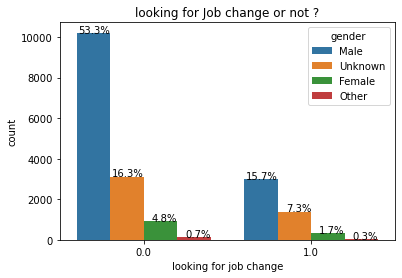

In [8]:
ax = sns.countplot(x="target",data=df1, hue="gender")
total =float(len(df))

plt.title("looking for Job change or not ?")
plt.xlabel("looking for job change")

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right')
plt.show()


**Observation:**
* Around 25% people are lookging for a job change
* Out of which, 15.7% people are male
* Around 80% people are currently not looking for job change

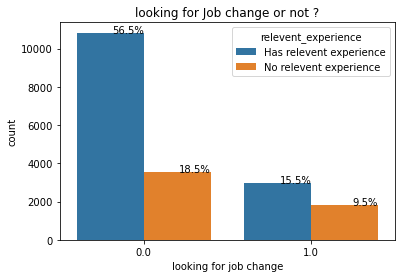

In [9]:
ax = sns.countplot(x="target",data=df1, hue="relevent_experience")
total =float(len(df))

plt.title("looking for Job change or not ?")
plt.xlabel("looking for job change")

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right')
plt.show()


Observation:
* Out of those who looks for job change, 15.5 % have relevent experience.

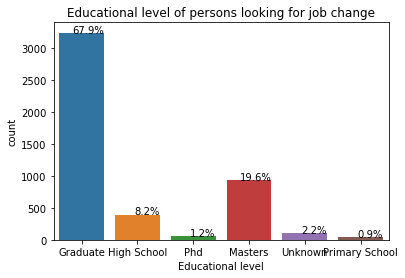

In [10]:
ax = sns.countplot(x="education_level",data=df1[df1['target']==1])
total_1 =float(len(df[df['target']==1]))
plt.title("Educational level of persons looking for job change")
plt.xlabel("Educational level")

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total_1)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right')
plt.show()


Observation:
* Graduates are more likely to look for a job change. 

Text(0.5, 0, 'looking for job change')

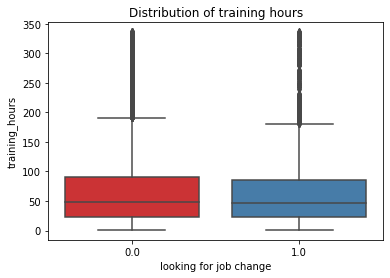

In [11]:
sns.boxplot(x="target",y="training_hours",data=df1,palette="Set1")
plt.title("Distribution of training hours")
plt.xlabel("looking for job change")

**Observation:**
*  Average training hours completed is almost same for people who are looking for job and not. It means training hours doesnt have impact here

Text(0.5, 0, 'looking for job change')

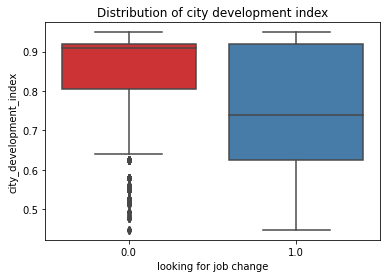

In [12]:
sns.boxplot(x="target",y="city_development_index",data=df1,palette="Set1")
plt.title("Distribution of city development index")
plt.xlabel("looking for job change")

**Observation**
* Average city development index for people who are looking for job change is less. So, people from city which has higher development index are less likely to look for job change

Text(0.5, 1.0, 'looking for job change (major discipline wise)')

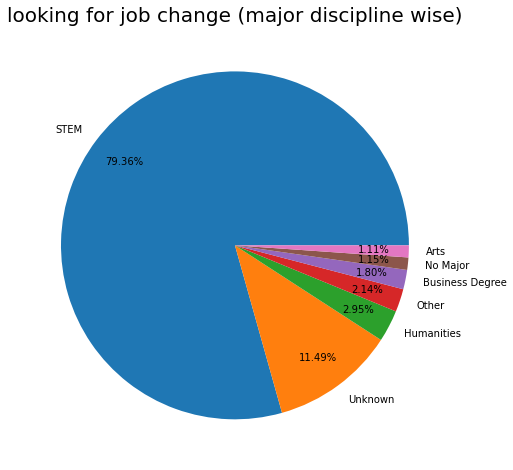

In [13]:
major_discipline = df1[df1['target'] == 1]['major_discipline']
values = major_discipline.value_counts()
labels = values.keys()
bar,ax = plt.subplots(figsize=(8,8))
plt.pie(x = values, labels = labels , autopct="%.2f%%",pctdistance=0.8)
plt.title('looking for job change (major discipline wise)', fontsize=20)

**Observation**:
* Around 80% of STEM degree holders are looking fot job change. So, It might be possible that they are more likely to look for job changes 

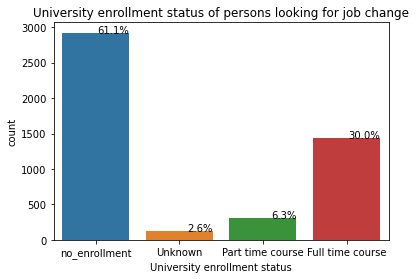

In [14]:
ax = sns.countplot(x="enrolled_university",data=df1[df1['target']==1])
total_1 =float(len(df[df['target']==1]))
plt.title("University enrollment status of persons looking for job change")
plt.xlabel("University enrollment status")

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total_1)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right')
plt.show()

**Observation:**
* Around 37% of people who are leaving the job are due to higher studies. Around 61% of the people havent enrolled in any educational courses. So, they might be leaving the job due to other reasons such as salary issues, job satisfaction, etc

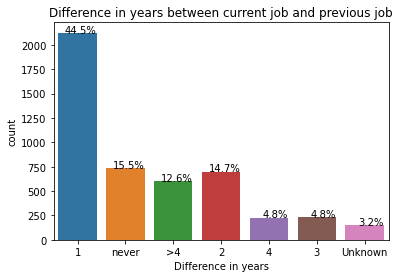

In [15]:
ax = sns.countplot(x="last_new_job",data=df1[df1['target']==1])
total_1 =float(len(df[df['target']==1]))
plt.title("Difference in years between current job and previous job")
plt.xlabel("Difference in years")

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total_1)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right')
plt.show()

**Observation:**
* Around 44.5 % of the people who are looking out for job change have only one year of difference between their current job and previus job. One of the possible reasons could be, they might not like the work culture of the company

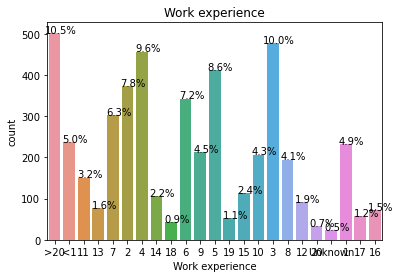

In [16]:
ax = sns.countplot(x="experience",data=df1[df1['target']==1])
total_1 =float(len(df[df['target']==1]))
plt.title("Work experience")
plt.xlabel("Work experience")

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total_1)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

**Observation**
* People with experience 2,3,4,5 and >20 are mor likely to look for job change

# Data preparation and encoding

In [17]:
#Checking for percentage of missing values in each columns
(df.isnull().sum()/len(df))*100

enrollee_id                0.000000
city                       0.000000
city_development_index     0.000000
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
last_new_job               2.207955
training_hours             0.000000
target                     0.000000
dtype: float64

* Replacing the missing values by mode value for columns that have more than 5% of missing values

In [18]:
#Mode Imputation
df['gender'] = df['gender'].fillna(df['gender'].mode()[0])
df['major_discipline'] = df['major_discipline'].fillna(df['major_discipline'].mode()[0])
df['company_size'] = df['company_size'].fillna(df['company_size'].mode()[0])
df['company_type'] = df['company_type'].fillna(df['company_type'].mode()[0])

In [19]:
#Dropping rest of the null values
df.dropna(inplace=True)

In [20]:
df.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [21]:
df.shape

(18014, 14)

In [22]:
#Encoding experience column
experience_mapper = {
    '<1'      :    0,'1'       :    1, '2'       :    2, '3'       :    3, '4'       :    4, '5'       :    5,
    '6'       :    6,'7'       :    7,'8'       :    8,  '9'       :    9, '10'      :    10, '11'      :    11,
    '12'      :    12,'13'      :    13, '14'      :    14, '15'      :    15, '16'      :    16,'17'      :    17,
    '18'      :    18,'19'      :    19, '20'      :    20, '>20'     :    21
} 
df.loc[:,'experience'] = df['experience'].map(experience_mapper)  

In [23]:
#Encoding rest of the columns
le = preprocessing.LabelEncoder() 
df['last_new_job']  = le.fit_transform(df['last_new_job']) 
df2=pd.get_dummies(df,columns=['gender','relevent_experience','enrolled_university','education_level','major_discipline','company_size','company_type'],drop_first=True)
df2.head()

,enrollee_id,city,city_development_index,experience,last_new_job,training_hours,target,gender_Male,gender_Other,relevent_experience_No relevent experience,...,company_size_10000+,company_size_50-99,company_size_500-999,company_size_5000-9999,company_size_<10,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd
0,8949,city_103,0.920,21,0,36,1.0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
1,29725,city_40,0.776,15,4,47,0.0,1,0,1,...,0,1,0,0,0,0,0,0,0,1
2,11561,city_21,0.624,5,5,83,0.0,1,0,1,...,0,1,0,0,0,0,0,0,0,1
4,666,city_162,0.767,21,3,8,0.0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
5,21651,city_176,0.764,11,0,24,1.0,1,0,0,...,0,1,0,0,0,0,0,0,0,1


In [24]:
#Dropping unnecessary columns
df2.drop(['enrollee_id','city'],axis=1,inplace=True)
df2.head()

,city_development_index,experience,last_new_job,training_hours,target,gender_Male,gender_Other,relevent_experience_No relevent experience,enrolled_university_Part time course,enrolled_university_no_enrollment,...,company_size_10000+,company_size_50-99,company_size_500-999,company_size_5000-9999,company_size_<10,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd
0,0.920,21,0,36,1.0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
1,0.776,15,4,47,0.0,1,0,1,0,1,...,0,1,0,0,0,0,0,0,0,1
2,0.624,5,5,83,0.0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0.767,21,3,8,0.0,1,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
5,0.764,11,0,24,1.0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


In [25]:
#Checking if there is any imbalances in the dataset
df2.groupby('target')['target'].count()

target
0.0    13593
1.0     4421
Name: target, dtype: int64

**Observation:**
* Dataset is imbalanced. Lets use SMOTE technique to resolve this issue


In [26]:
X = df2.drop(['target'],axis=1)
y = df2['target']

sm = SMOTE(random_state=42)
X_smote,y_smote = sm.fit_sample(X,y)

count_class = Counter(y_smote)
print(count_class)

Counter({1.0: 13593, 0.0: 13593})


In [27]:
#Renaming this specific column because it contains '<' in the column name
X_smote.rename(columns={'company_size_<10':'company_size_10'}, inplace=True)

# Model Selection and Building

Comparison between SVM and XGboost

In [28]:
models = {
    'SVM':{'model':svm.SVC(gamma='auto',C=5,kernel='rbf'),'params': {'C': [1,5,10]}},
    'xgboost':{'model':xgb.XGBClassifier(),'params': {'max_depth':[4,6,8],'gamma': [0.5, 1, 2, 5]}}
}

In [29]:
#Hyperparameters tuning using GridSearchCV
scores = []

for model_name, mp in models.items():
    clf =  GridSearchCV(mp['model'],mp['params'] ,cv= 2, return_train_score=False)
    clf.fit(X_smote, y_smote)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_model = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_model

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:27:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:27:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:27:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:27:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,model,best_score,best_params
0,SVM,0.758883,{'C': 10}
1,xgboost,0.782241,"{'gamma': 0.5, 'max_depth': 8}"


**Observation**
* Xgboost performs well than SVM in this case

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.3, random_state=42)

In [31]:
model = xgb.XGBClassifier(gamma=0.5,max_depth=8)
model.fit(X_train,y_train)
ypred = model.predict(X_test)
print(classification_report(y_test,ypred))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:27:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84      4141
         1.0       0.83      0.83      0.83      4015

    accuracy                           0.83      8156
   macro avg       0.83      0.83      0.83      8156
weighted avg       0.83      0.83      0.83      8156



In [32]:
print("Xgboost model accuracy - ", accuracy_score(y_test,ypred)*100)

Xgboost model accuracy -  83.49681216282492


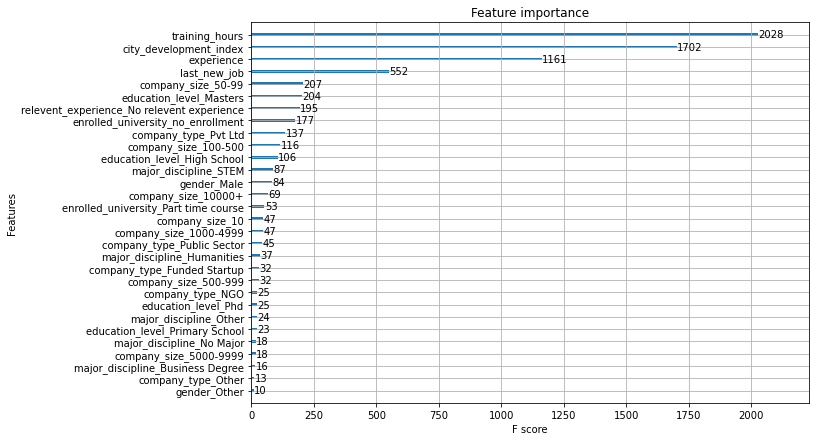

In [33]:
#Plotting features importance
plt.rcParams["figure.figsize"] = (10, 7)
plot_importance(model)
plt.show()